## Quantized Tranfer learning

**Transfer learning** : it is the process of reuse of a pre-trained model on a new problem.

**Quantization** : Quantization is part of that process that convert a continuous data can be infinitely small or big to discrete numbers within a fixed range, say numbers 0, 1, 2, .., 255(8 bit int) which are commonly used in digital image files.



**benefit of quantization** : faster training on cpu(2.x 3.x time more speed),speeding up memory(weigth) tranfer(memory to cores),less memoery storage



In [1]:
import numpy as np
import zipfile
import os
import time
import copy
import matplotlib
import torch
import torchvision
import torchaudio
from platform import python_version


C:\Users\ASUS\anaconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\ASUS\anaconda3\lib\site-packages\torchaudio\backend\utils.py:88: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [3]:
print('phython version     : ' + (python_version()))
print('numpy version       : ' + np.__version__)
print('pytorch version     : ' + torch.__version__)
print('torchvision version : ' + torchvision.__version__)
print('matplotlib version  : '+matplotlib.__version__)
print(torchaudio.__version__)



phython version     : 3.8.3
numpy version       : 1.18.5
pytorch version     : 1.7.1
torchvision version : 0.8.2
matplotlib version  : 3.2.2
0.7.2


### Loading the dataset

In [3]:
path = 'D:\hymenoptera_data.zip'
zip_ref = zipfile.ZipFile(path,'r')
zip_ref.extractall('bees&ant')
zip_ref.close()

In [4]:
train_ants_dir = os.path.join('bees&ant/hymenoptera_data/train/ants')
train_bees_dir = os.path.join('bees&ant/hymenoptera_data/train/bees')
test_ants_dir = os.path.join('bees&ant/hymenoptera_data/val/ants')
test_bees_dir = os.path.join('bees&ant/hymenoptera_data/val/bees')

In [5]:
train_ants_names = os.listdir(train_ants_dir)
train_bees_names = os.listdir(train_bees_dir)
test_ants_names = os.listdir(test_ants_dir)
tes_bees_names = os.listdir(test_bees_dir)

In [6]:
print('no. of training images of ants : ' + str(len(train_ants_names)))
print('no. of training images of bees : ' + str(len(train_bees_names)))
print('no. of test images of ants     : ' + str(len(test_ants_names)))
print('no. of test images of bees     : ' + str(len(train_bees_names)))

no. of training images of ants : 124
no. of training images of bees : 121
no. of test images of ants     : 70
no. of test images of bees     : 121


### Visulaizing the training set

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

pic_index_intial = 0


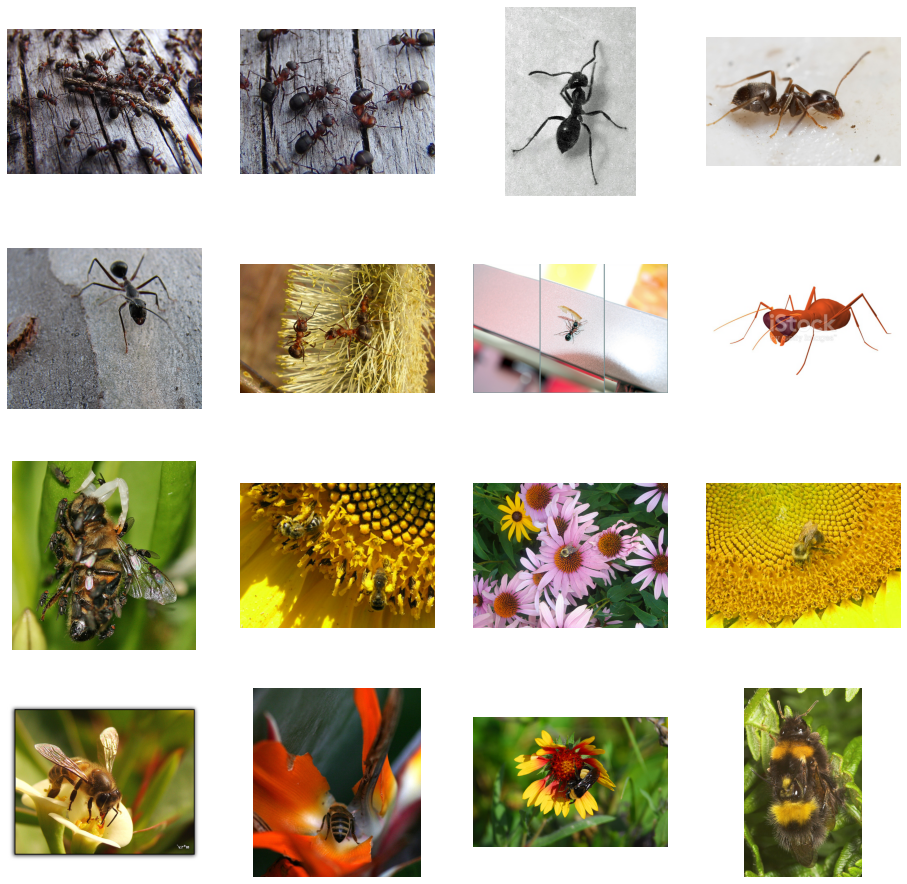

['bees&ant/hymenoptera_data/train/ants\\150801003_3390b73135.jpg', 'bees&ant/hymenoptera_data/train/ants\\150801171_cd86f17ed8.jpg', 'bees&ant/hymenoptera_data/train/ants\\154124431_65460430f2.jpg', 'bees&ant/hymenoptera_data/train/ants\\162603798_40b51f1654.jpg', 'bees&ant/hymenoptera_data/train/ants\\1660097129_384bf54490.jpg', 'bees&ant/hymenoptera_data/train/ants\\167890289_dd5ba923f3.jpg', 'bees&ant/hymenoptera_data/train/ants\\1693954099_46d4c20605.jpg', 'bees&ant/hymenoptera_data/train/ants\\175998972.jpg']
['bees&ant/hymenoptera_data/train/bees\\1807583459_4fe92b3133.jpg', 'bees&ant/hymenoptera_data/train/bees\\196430254_46bd129ae7.jpg', 'bees&ant/hymenoptera_data/train/bees\\196658222_3fffd79c67.jpg', 'bees&ant/hymenoptera_data/train/bees\\198508668_97d818b6c4.jpg', 'bees&ant/hymenoptera_data/train/bees\\2031225713_50ed499635.jpg', 'bees&ant/hymenoptera_data/train/bees\\2037437624_2d7bce461f.jpg', 'bees&ant/hymenoptera_data/train/bees\\2053200300_8911ef438a.jpg', 'bees&ant/hym

In [20]:
# Set up matplotlib fig, and size it to fit 4x4 pics

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index_final = pic_index_intial + 8

next_ants_pic = [os.path.join(train_ants_dir, fname) for fname in train_ants_names[pic_index_intial:pic_index_final]]
next_bees_pic = [os.path.join(train_bees_dir, fname) 
                for fname in train_bees_names[pic_index_intial:pic_index_final]]

pic_index_intial = pic_index_final

for  i,img_path in enumerate(next_ants_pic+next_bees_pic):
    sp = plt.subplot(nrows,ncols,i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


print(next_ants_pic)
print(next_bees_pic)

### Data argumentaion and normalization


we will going to use the Resnet18 model,for which the specified mean and standard deviation are [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],we will use them for moramlization of valdaition set and training set

In [9]:


import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'bees&ant/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = 'cpu'

### Function to calulate the loss accuracy & saving the best accuracy model

In [10]:
#train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True, num_workers=8)
#val_loader   = torch.utils.data.DataLoader(val_dataset,batch_size=16,shuffle=True, num_workers=8)

In [11]:
def train_model(model, criterion, optimizer,scheduler,num_epochs=25, device='cpu'):
      """
      Support function for model training.

      Args:
        model: Model to be trained
        criterion: Optimization criterion (loss)
        optimizer: Optimizer to use for training
        scheduler: Instance of ``torch.optim.lr_scheduler``
        num_epochs: Number of epochs
        device: Device to run the training on. Must be 'cpu' or 'cuda'
      """
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0

      for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
          if phase == 'train':
            model.train()  # Set model to training mode
          else:
            model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
            scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
      return model

#### importing the pretrained resnet18 mode(including the quatization) and using the pretrained weight, we will created a new head of 2 neuron  since we are have only 2 classes,and then we will only traing the head part



In [12]:
import torchvision.models.quantization as models

model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features ##no. of features

C:\Users\ASUS\anaconda3\lib\site-packages\torch\quantization\observer.py:119: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [13]:
from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  #a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.45),  #using drop out to avoid overfiiting
    nn.Linear(num_ftrs, 2),
  )

  
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model


#### Using the adam optimizer and setting the learning rate to 0.01 

In [14]:
import torch.optim as optim
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(new_model.parameters(), lr=0.01) 

# Decay LR by a factor of 0.01 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.01)

In [15]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=14, device='cpu')

Epoch 0/13
----------
train Loss: 0.5668 Acc: 0.7500
val Loss: 0.2004 Acc: 0.9542

Epoch 1/13
----------
train Loss: 0.2663 Acc: 0.9057
val Loss: 0.1922 Acc: 0.9477

Epoch 2/13
----------
train Loss: 0.2068 Acc: 0.9262
val Loss: 0.2561 Acc: 0.9281

Epoch 3/13
----------
train Loss: 0.2660 Acc: 0.9098
val Loss: 0.2079 Acc: 0.9608

Epoch 4/13
----------
train Loss: 0.1701 Acc: 0.9508
val Loss: 0.2394 Acc: 0.9608

Epoch 5/13
----------
train Loss: 0.1282 Acc: 0.9344
val Loss: 0.2463 Acc: 0.9477

Epoch 6/13
----------
train Loss: 0.1867 Acc: 0.9426
val Loss: 0.2172 Acc: 0.9542

Epoch 7/13
----------
train Loss: 0.1241 Acc: 0.9590
val Loss: 0.2199 Acc: 0.9477

Epoch 8/13
----------
train Loss: 0.0993 Acc: 0.9590
val Loss: 0.2226 Acc: 0.9477

Epoch 9/13
----------
train Loss: 0.0716 Acc: 0.9754
val Loss: 0.2238 Acc: 0.9477

Epoch 10/13
----------
train Loss: 0.0775 Acc: 0.9631
val Loss: 0.2286 Acc: 0.9477

Epoch 11/13
----------
train Loss: 0.1030 Acc: 0.9631
val Loss: 0.2287 Acc: 0.9477

Ep

# part 2

### we will fine tune the complete model here,and train the weight then  will qautized the feature in forward pass ,this will lead to higher accuracy along with the benift of quantization

Quantization only supported inn forward pass,for traing the weigths the backward propogation we need to use the dequantized model then after traing we qauntized the the model for forward pass 

In [16]:
# notice `quantize=False`
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# Step 1
model.train()
model.fuse_model()
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)



In [17]:
for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                              num_epochs=5, device=device)

Epoch 0/4
----------
train Loss: 0.5644 Acc: 0.7828
val Loss: 13.2262 Acc: 0.5556

Epoch 1/4
----------
train Loss: 0.5399 Acc: 0.7336
val Loss: 2.6873 Acc: 0.5425

Epoch 2/4
----------
train Loss: 0.6419 Acc: 0.6639
val Loss: 0.5707 Acc: 0.6928

Epoch 3/4
----------
train Loss: 0.6544 Acc: 0.6885
val Loss: 2.9663 Acc: 0.4771

Epoch 4/4
----------
train Loss: 0.6329 Acc: 0.6475
val Loss: 0.7170 Acc: 0.4706

Training complete in 8m 27s
Best val Acc: 0.692810


In [18]:
from torch.quantization import convert
model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)